# rGREAT online vs rGreat local vs greatpy

This notebook allows you to compare results between local rGreat online, rGREAT local and enrichment function from greatpy. 

r-base == 3.6.1

python version == 3.8 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import rpy2
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects import r as r
# pandas2ri.activate()
import pandas as pd

import os 
import matplotlib.pyplot as plt
import greatpy as great 
from scipy.stats import pearsonr
import re
import time 
import seaborn as sns 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# rpy2.__version__

In [4]:
# importr('rGREAT')
# ranges = importr('GenomicRanges')

In [11]:
def rgreat_online_vs_local_vs_greatpy(): 
    stat_df = {
        "name" : [],
        "pearson_binom" : [], 
        "pearson_hypergeom" : []
    }
    pp = {
        "name" : [],
        "before_pp_greatpy_size" : [], 
        "before_pp_local_size" : [],
        "final_size" : [],
        "%_of_diffrent_GO_term" : [],
    }
    test_file = ["01_random.bed","04_ultra_hg38.bed","06_height_snps_hg38.bed","07_height_snps_hg19.bed","10_MAX.bed"]

    ann = pd.read_csv("../../data/human/ontologies.csv",sep=';',comment='#',header=0,)
    ann["name"] = ann['name'].str.lower()
    table = pd.DataFrame()

    res = {"name1":[],"file":[],"name3":[],"value":[]}

    for name in test_file : 
        # find the assembly 
        # if re.match(".*hg19.*",name) != None : 
        #     assembly = "hg19"
        # else : 
        #     assembly = "hg38"

        # # online test 
        # res_online = rpy2.robjects.r['submitGreatJob'](f"../../data/tests/test_data/input/{name}",species=f"{assembly}",help=False)
        # res_online = rpy2.robjects.r['getEnrichmentTables'](res_online)

        # time.sleep(30)

        # # local test
        #     # proprocessing : make a Grange frame 
        # df = r["read.csv"](f"../../data/tests/test_data/input/{name}",sep='\t')
        # seqname = rpy2.robjects.StrVector(["seqnames", "seqname","chromosome", "X.Chr","chr", "chromosome_name","seqid"])
        # end = rpy2.robjects.StrVector(['end', 'stop'])
        # df = ranges.makeGRangesFromDataFrame(df,seqnames_field=seqname)

        #     # great calculation
        # local = rpy2.robjects.r['great'](df, "GREAT:C5", f"txdb:{assembly}",verbose=False)
        # local = rpy2.robjects.r['getEnrichmentTables'](local)

        # time.sleep(30)

        # # greatpy calculation
        # greatpy = great.tl.GREAT.enrichment(
        #     test_file=f"../../data/tests/test_data/input/{name}",
        #     regdom_file=f"../../data/human/{assembly}/regulatory_domain.bed",
        #     chr_size_file=f"../../data/human/{assembly}/chr_size.bed",
        #     annotation_file=f"../../data/human/ontologies.csv",
        #     binom=True,
        #     hypergeom=True,
        #     )
        # time.sleep(30)

        # # create each dataframe
        #     # online
        # name_online = [cdc.lower() for cdc in list(res_online.rx2("GO Molecular Function").rx2("name"))+list(res_online.rx2("GO Biological Process").rx2("name"))+list(res_online.rx2("GO Cellular Component").rx2("name"))]
        # online = pd.DataFrame({
        #     "id" : list(res_online.rx2("GO Molecular Function").rx2("ID"))+list(res_online.rx2("GO Biological Process").rx2("ID"))+list(res_online.rx2("GO Cellular Component").rx2("ID")),
        #     "name" : name_online,
        #     "binom_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Binom_Raw_PValue")),
        #     "hyper_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Hyper_Raw_PValue"))
        #     })

        #     # local
        # name_local = list(local.rx2("id")) 
        # name_local = [" ".join(cdc.lower().split("_")[1:]) for cdc in list(local.rx2("id"))]
        # local = pd.DataFrame({
        #     "name": name_local,
        #     "binom_p_val" : list(local.rx2("p_value")),
        #     "hyper_p_val" : list(local.rx2("p_value_hyper"))
        #     })

        file_out = name.split(".")
        greatpy = pd.read_csv(f"../../../{file_out[0]}.out",sep = ",",header=0,index_col=0)
        local = pd.read_csv(f"../../../{file_out[0]}.out_local.out",sep=',',header=0,index_col=0)
        online = pd.read_csv(f"../../../{file_out[0]}.out_online.out",sep=',',header=0,index_col=0)

            # greatpy
        greatpy["go_term"] = greatpy["go_term"].str.lower()

        # correlation between online and greatpy 
        o_great = online[online["id"].isin(list(greatpy.index))]
        great_o = greatpy[greatpy.index.isin(list(online["id"]))]

        tot = pd.DataFrame()
        res_bin=[]
        res_hyp=[]
        cols_to_supr = []
        for i in range(len(o_great)) : 
            curr_o = o_great.iloc[i]
            if greatpy.loc[greatpy.index == curr_o["id"]].shape[0] > 0 : 
                res_bin.append( float(greatpy.loc[greatpy.index == curr_o["id"]]["binom_p_value"]) )
                res_hyp.append( float( greatpy.loc[greatpy.index == curr_o["id"]]["hypergeom_p_value"] ))
            else : 
                cols_to_supr.append(i)
        
        tot["id"] = o_great["id"]
        tot["binom_p_value_online"] = -np.log(list(o_great["binom_p_val"]))
        tot["hyper_p_value_online"] = -np.log(list(o_great["hyper_p_val"]))
        tot["binom_p_value_greatpy"] = -np.log(res_bin)
        tot["hypergeom_p_value_greatpy"] = -np.log(res_hyp)

        # add GO id to local 
        go = []
        for i in range(local.shape[0]) : 
            curr = local.iloc[i]

            if ann.loc[ann["name"].isin([curr["name"]])].shape[0]>0 : 
                go.append(ann.loc[ann["name"].isin([curr["name"]])].iloc[0]["id"])
            else :
                go.append("")
        local["id"] = go 
        local = local.loc[local["id"]!=""]

        # Correlation between online and local 
        o_loc = online[online["id"].isin(local["id"])]
        loc_o = local[local["id"].isin(online["id"])]
        tot_2 = pd.DataFrame()

        res_bin=[]
        res_hyp=[]
        cols_to_supr = []
        for i in range(len(o_loc)) : 
            curr_o = o_loc.iloc[i]
            if loc_o.loc[loc_o["id"] == curr_o["id"]].shape[0] > 0 : 
                res_bin.append(float(loc_o.loc[loc_o["id"] == curr_o["id"]].iloc[0]["binom_p_val"]) )
                res_hyp.append(float(loc_o.loc[loc_o["id"] == curr_o["id"]].iloc[0]["hyper_p_val"] ))
            else : 
                cols_to_supr.append(i)
        tot_2["id"] = o_loc["id"]
        tot_2["binom_p_value_online"] = -np.log(list(o_loc["binom_p_val"]))
        tot_2["hyper_p_value_online"] = -np.log(list(o_loc["hyper_p_val"]))
        tot_2["binom_p_value_local"] = -np.log(res_bin)
        tot_2["hypergeom_p_value_local"] = -np.log(res_hyp)

        # Correlation between greatpy and local 
        g_loc = greatpy[greatpy.index.isin(local["id"])]
        loc_g = local[local["id"].isin(greatpy.index)]
        tot_3 = pd.DataFrame()

        res_bin=[]
        res_hyp=[]
        cols_to_supr = []
        g_loc = g_loc.reset_index().rename(columns={"index":"id"})
        for i in range(g_loc.shape[0]) :  
            curr_o = g_loc.iloc[i]
            if loc_g.loc[loc_g["id"] == curr_o["id"]].shape[0] > 0 : 
                res_bin.append(float(loc_g.loc[loc_g["id"] == curr_o["id"]].iloc[0]["binom_p_val"]) )
                res_hyp.append(float(loc_g.loc[loc_g["id"] == curr_o["id"]].iloc[0]["hyper_p_val"] ))
            else : 
                cols_to_supr.append(i)
        tot_3["id"] = g_loc["id"]
        tot_3["binom_p_value_greatpy"] = -np.log(list(g_loc["binom_p_value"]))
        tot_3["hyper_p_value_greatpy"] = -np.log(list(g_loc["hypergeom_p_value"]))
        tot_3["binom_p_value_local"] = -np.log(res_bin)
        tot_3["hypergeom_p_value_local"] = -np.log(res_hyp)

        tot = tot.replace(np.inf,np.nan)
        tot_2 = tot_2.replace(np.inf,np.nan)
        tot_3 = tot_3.replace(np.inf,np.nan)
        
        tot = tot.dropna()
        tot_2 = tot_2.dropna()
        tot_3 = tot_3.dropna()

        # create the table 
        

        name_plot = " ".join(name.split(".")[0].split("_")[1:])

        # res["name1"].append("greatpy")
        # res["name3"].append("greatpy")
        # res["value"].append(pearsonr(tot["binom_p_value_greatpy"],tot["binom_p_value_greatpy"])[0])

        res["name1"].append("online")
        res["file"].append(name_plot)
        res["name3"].append("greatpy")
        res["value"].append(pearsonr(tot["binom_p_value_online"],tot["binom_p_value_greatpy"])[0])

        # res["name1"].append("greatpy")
        # res["name3"].append("online")
        # res["value"].append(pearsonr(tot["binom_p_value_greatpy"],tot["binom_p_value_online"])[0])

        res["name1"].append("online")
        res["file"].append(name_plot)
        res["name3"].append("local")
        res["value"].append(pearsonr(tot_2["binom_p_value_online"],tot_2["binom_p_value_local"])[0])

        # res["name1"].append("local")
        # res["name3"].append("online")
        # res["value"].append(pearsonr(tot_2["binom_p_value_online"],tot_2["binom_p_value_local"])[0])

        # res["name1"].append("online")
        # res["name3"].append("online")
        # res["value"].append(pearsonr(tot["binom_p_value_online"],tot["binom_p_value_online"])[0])

        # res["name1"].append("local")
        # res["name3"].append("greatpy")
        # res["value"].append(pearsonr(tot_3["binom_p_value_greatpy"],tot_3["binom_p_value_local"])[0])

        # res["name1"].append("greatpy")
        # res["name3"].append("local")
        # res["value"].append(pearsonr(tot_3["binom_p_value_greatpy"],tot_3["binom_p_value_local"])[0])
        
        # res["name1"].append("local")
        # res["name3"].append("local")
        # res["value"].append(pearsonr(tot_2["binom_p_value_local"],tot_2["binom_p_value_local"])[0])

        # test = pd.DataFrame(res)
        # test = test.pivot("name1","name3","value")
        # test["file"] = [name_plot]*test.shape[0]
        # test = test.set_index("file",append=True).reorder_levels(["file","name1"])
        # if table.shape[0] == 0 : 
        #     table = test 
        # else : 
        #     table = pd.concat([table, test])

        # g = sns.clustermap(test,figsize=(3,3),annot = True)
        # g.ax_heatmap.set_title(f"{name}")

    res = pd.DataFrame(res)
    res = res.pivot("file","name3","value")
    g = sns.heatmap(data=res,cmap="Reds",annot=True)
    g.set_title("correlation with GREAT server")
    g.set_ylabel("online results for each file")
    g.set_xlabel("algorithm results for each file")
        
    plt.show(g)

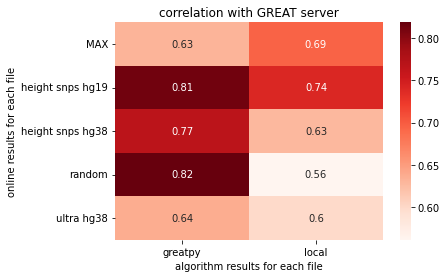

In [12]:
rgreat_online_vs_local_vs_greatpy()

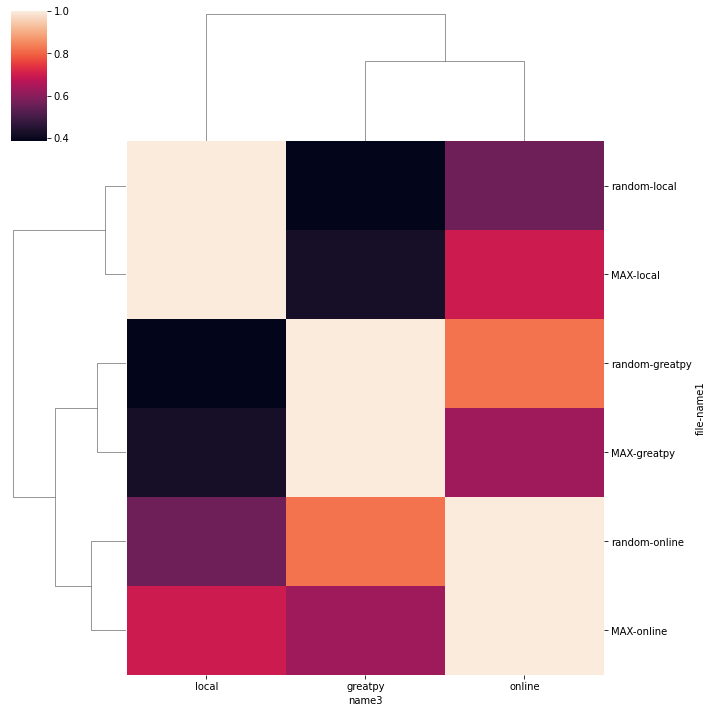

In [103]:
sns.clustermap(test)

## Compare greatpy and online with threshold = 0.05 on fdr correction 

In [7]:
from statsmodels.stats.multitest import multipletests

In [8]:
stat = {
        "name" : [], 
        "binom_correlation" : [],
    }

for name in ["01_random.bed","06_height_snps_hg38.bed","07_height_snps_hg19.bed","10_MAX.bed"] : 
    file_out = name.split(".")
    greatpy = pd.read_csv(f"../../../{file_out[0]}.out",sep = ",",header=0,index_col=0)
    online = pd.read_csv(f"../../../{file_out[0]}.out_online.out",sep=',',header=0,index_col=0) 

    online["binom_fdr"] = multipletests(online["binom_p_val"], alpha=0.05, method='fdr_bh')[1]

    # réduction of df 
    greatpy = greatpy[greatpy["binom_fdr"] <= 0.1]
    online = online[online["binom_fdr"] <= 0.1]

    print(f"after threshold : greatpy shape = {greatpy.shape[0]}, online shape = {online.shape[0]}")
    greatpy = greatpy[greatpy.index.isin(list(online["id"]))]
    online = online[online["id"].isin(list(greatpy.index))]

    print(f"after get same go ID : greatpy shape = {greatpy.shape[0]}, online shape = {online.shape[0]} \n")

    
    stat["name"].append(file_out[0])
    try : 
        stat["binom_correlation"].append(pearsonr(online["binom_fdr"],greatpy["binom_fdr"])[0])
    except : 
        stat["binom_correlation"].append(f"Error : df.shape = {online.shape[0]}")

pd.DataFrame(stat)


after threshold : greatpy shape = 292, online shape = 144
after get same go ID : greatpy shape = 82, online shape = 82 

after threshold : greatpy shape = 494, online shape = 577
after get same go ID : greatpy shape = 217, online shape = 217 

after threshold : greatpy shape = 553, online shape = 652
after get same go ID : greatpy shape = 242, online shape = 242 

after threshold : greatpy shape = 3, online shape = 17
after get same go ID : greatpy shape = 1, online shape = 1 



,name,binom_correlation
0,01_random,3.74254e-01
1,06_height_snps_hg38,4.73357e-01
2,07_height_snps_hg19,3.94162e-01
3,10_MAX,Error : df.shape = 1
